## 📦 Installing Required Libraries and Importing Modules
We start by installing the `transformers` library, which gives us access to pre-trained Vision Transformer (ViT) models from Hugging Face.  
We then import all the essential PyTorch, torchvision, and Transformers modules that will help us handle datasets, transformations, and deep learning tasks.


In [ ]:
# Install the transformers library if not installed
!pip install transformers


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification
import os


## 💻 Setting Up Device (GPU or CPU)
We check if a GPU is available for faster training; otherwise, we default to CPU.  
This ensures the model runs optimally based on the hardware available.


In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 🔗 Mounting Google Drive
Since our dataset is stored in Google Drive, we mount it here to access training and testing images directly from the drive.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📂 Dataset Directory Setup
We define the paths for training and testing datasets.  
In this example, we're working with the **100X magnification subset** of the BreakHis dataset.


## 🖼️ Image Transformations
Before training, our images need to be resized and normalized.  
Here’s what we do:
- **Resize** to 224×224 pixels (ViT’s input size)
- **Convert to Tensor** so PyTorch can process them
- **Normalize** pixel values to the range [-1, 1] for stable training


## 📥 Loading the Dataset
We use `ImageFolder` to load training and testing datasets with the defined transformations.  
This also automatically assigns labels based on folder names and gives us a `class_names` list.


In [ ]:
# Set up the directory paths for the dataset
train_dir = '/content/drive/MyDrive/100x/training'
val_dir = '/content/drive/MyDrive/100x/testing'

# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ViT input
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize the images
])

# Load the train and validation datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Check class names
class_names = train_dataset.classes
print(f"Class Names: {class_names}")



Class Names: ['Adenosis_0', 'ductalcarcenoma_1', 'fibroadenoma_0', 'lubolarcarcenoma_1', 'mucinouscarcenoma_1', 'papillarycarcenoma_1', 'phyllodestumor_0', 'tubolaradenoma_0']


## 📦 Creating DataLoaders
We define a batch size and create DataLoaders for both training and testing sets.  
DataLoaders help us:
- Efficiently feed batches of data to the model
- Shuffle training data for better learning


In [ ]:
# Define batch size
batch_size = 32

# Create DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## 👀 Visualizing Dataset Samples
Before training, it’s a good practice to check sample images.  
We define helper functions:
- **imshow()** → converts tensors back to images for display
- **visualize_dataset_samples()** → shows multiple images with their true labels


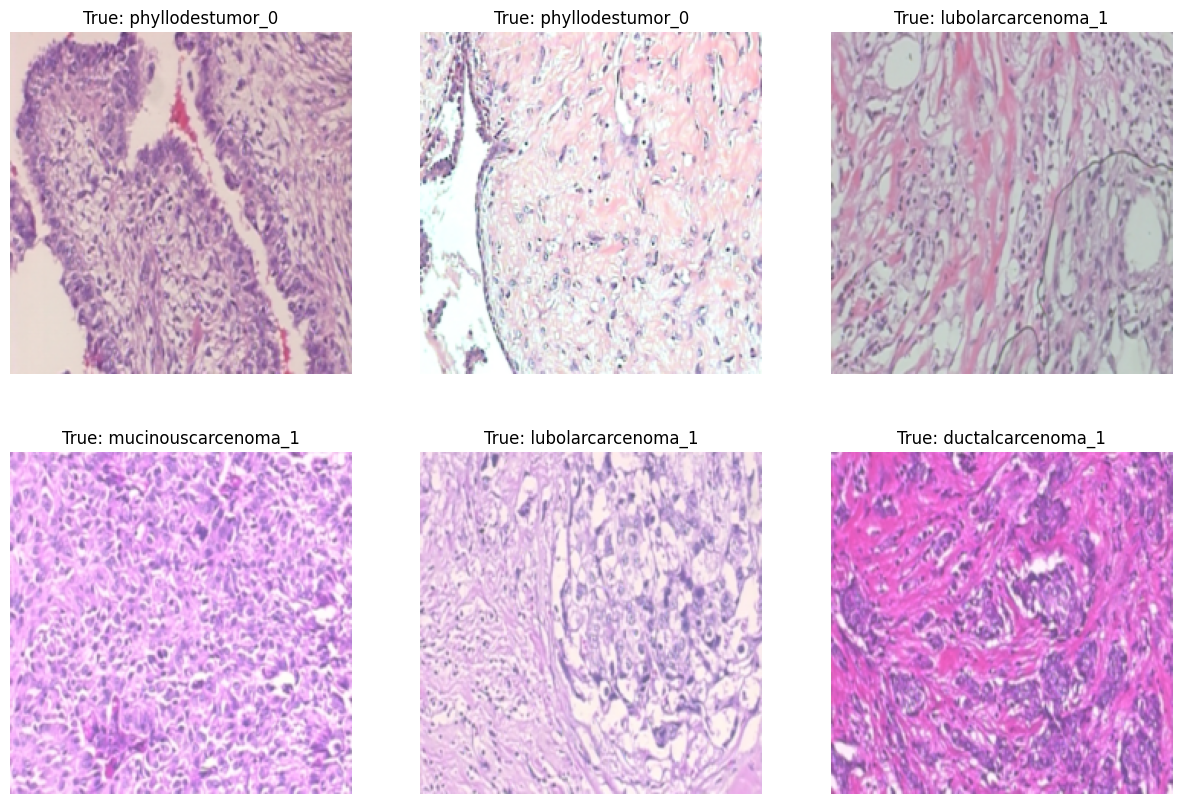

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image with a title
def imshow(image_tensor, title):
    """Function to plot an image from a tensor"""
    image = image_tensor.numpy().transpose((1, 2, 0))  # Convert to HWC format for plotting
    image = np.clip((image * 0.5) + 0.5, 0, 1)  # Un-normalize the image for display
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Function to visualize a few images from the dataset
def visualize_dataset_samples(dataloader, class_names, num_images=6):
    """Visualize a few images from the dataset with their true labels"""
    images_displayed = 0
    fig = plt.figure(figsize=(15, 10))

    # Iterate over the dataloader to get a batch of images and labels
    for inputs, labels in dataloader:
        for i in range(inputs.size(0)):
            if images_displayed == num_images:
                return  # Stop after displaying num_images

            ax = fig.add_subplot(2, 3, images_displayed + 1, xticks=[], yticks=[])
            imshow(inputs[i].cpu(), f"True: {class_names[labels[i]]}")
            images_displayed += 1

# Example usage to display images from the train dataset
visualize_dataset_samples(train_loader, class_names, num_images=6)
plt.show()


## 🧠 Loading Pre-trained Vision Transformer
We load the `vit-base-patch16-224` model from Hugging Face.  
This model:
- Has been pre-trained on large-scale datasets
- Is fine-tuned here for our number of classes (benign/malignant subtypes)
- Uses `ignore_mismatched_sizes=True` to adjust the final layer automatically


In [ ]:
# Load a pretrained ViT model from Hugging Face and fine-tune it for your dataset
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',  # Pretrained ViT model
    num_labels=len(class_names),    # Number of classes in your dataset (e.g., 8)
    ignore_mismatched_sizes=True    # Ignore size mismatch for the classifier layer
)

# Move the model to the appropriate device (GPU/CPU)
model.to(device)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## ⚙️ Defining Loss Function and Optimizer
We use:
- **CrossEntropyLoss** → suitable for multi-class classification
- **Adam optimizer** with a learning rate of `1e-4` → efficient and widely used in fine-tuning transformers


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropy for multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer with learning rate 1e-4


## 🎯 Training Function
The `train_model()` function:
1. Loops over epochs
2. Processes batches of images
3. Calculates loss
4. Backpropagates errors
5. Updates weights
6. Prints loss and accuracy per epoch


In [ ]:
# Function for training the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=15):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Iterate over the training data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds / total_preds
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


## 🚀 Training the Model
We train the ViT model for `num_epochs=5`.  
This will fine-tune the pre-trained model on our BreakHis 200X dataset.


In [ ]:
# Train the model for a set number of epochs
num_epochs = 5  # Set the number of epochs
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)


Epoch 1, Loss: 0.0266, Accuracy: 0.9964
Epoch 2, Loss: 0.0102, Accuracy: 1.0000
Epoch 3, Loss: 0.0049, Accuracy: 1.0000
Epoch 4, Loss: 0.0032, Accuracy: 1.0000
Epoch 5, Loss: 0.0026, Accuracy: 1.0000


## 💾 Saving the Model
Once training is complete, we save the model weights to Google Drive for future use or evaluation.


In [ ]:
# Save the trained model in Google Drive
model_save_path = '/content/drive/MyDrive/MyModels/100x_vit_breakhis_classifier.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/MyModels/100x_vit_breakhis_classifier.pth


## 📦 Installing scikit-learn
We install `scikit-learn` to compute evaluation metrics like accuracy, precision, recall, F1-score, and confusion matrix.


In [ ]:
!pip install scikit-learn


## 📊 Model Evaluation Function
The `evaluate_model()` function:
- Sets the model to evaluation mode
- Disables gradient computation for efficiency
- Calculates loss, accuracy, precision, recall, and F1-score
- Returns predictions and ground truth for further analysis


In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np

# Function to evaluate the model on the validation/test set
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits  # Get model outputs
            loss = criterion(outputs, labels)  # Compute the loss

            # Accumulate the loss
            running_loss += loss.item() * inputs.size(0)

            # Get the predicted class
            _, preds = torch.max(outputs, 1)

            # Append true and predicted labels for further evaluation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute average loss
    avg_loss = running_loss / len(dataloader.dataset)

    # Calculate accuracy, F1 score, precision, and recall
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Print evaluation results
    print(f"Evaluation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return all_labels, all_preds, avg_loss, accuracy, f1, precision, recall

# Evaluate the model using the validation set
criterion = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification
labels, preds, val_loss, accuracy, f1, precision, recall = evaluate_model(model, val_loader, criterion)


Evaluation Loss: 0.1063
Accuracy: 0.9667
Precision: 0.9686
Recall: 0.9667
F1 Score: 0.9666


## 📝 Classification Report
We use `classification_report()` to get a detailed breakdown of performance for each class — including precision, recall, and F1-score.


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(labels, preds, target_names=class_names))


                      precision    recall  f1-score   support

          Adenosis_0       0.97      1.00      0.98        30
   ductalcarcenoma_1       0.94      1.00      0.97        30
      fibroadenoma_0       1.00      0.93      0.97        30
  lubolarcarcenoma_1       0.91      1.00      0.95        30
 mucinouscarcenoma_1       0.97      1.00      0.98        30
papillarycarcenoma_1       1.00      0.90      0.95        30
    phyllodestumor_0       1.00      0.93      0.97        30
    tubolaradenoma_0       0.97      0.97      0.97        30

            accuracy                           0.97       240
           macro avg       0.97      0.97      0.97       240
        weighted avg       0.97      0.97      0.97       240



## 🔍 Confusion Matrix
We create a confusion matrix to visualize how well the model classifies each category.  
This helps identify where the model might be making mistakes.


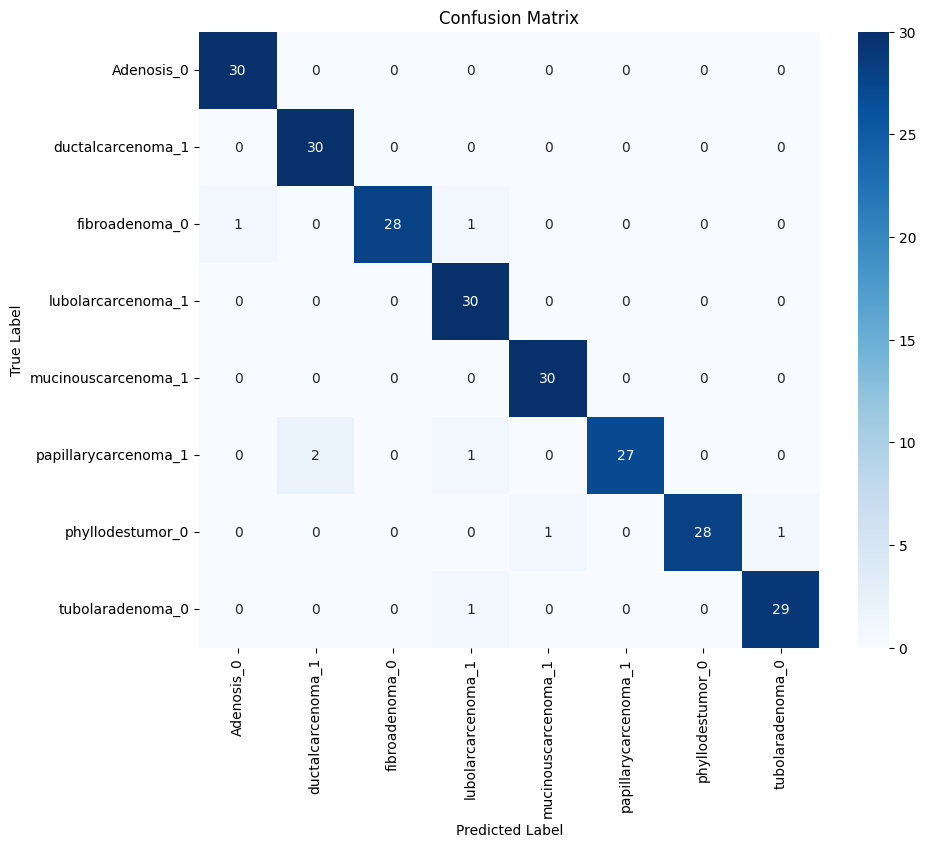

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
